In [8]:
from utils import *
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rdkit
import autode as ade

In [122]:
def load_conformers(path):

    conformers = [ade.Molecule(path+f, name=f"conf_cl_{cn}", charge=0, mult=1) for cn, f in enumerate(sorted(os.listdir(path))) if f.endswith(".xyz")]
    return conformers

def form_ensemble(conformers):

    conformers_cl = conformers
    conformers_no_cl = []
    for i, c in enumerate(conformers):
        atoms_no_cl = [atom for atom in c.atoms if atom.label != "Cl"]
        m = ade.Molecule(name=f"conf_{i}", charge=0, mult=1, atoms=atoms_no_cl)
        conformers_no_cl.append(m)
    
    ade_conformers_cl = ade.conformers.conformers.Conformers(conformers_cl)
    ade_conformers_no_cl = ade.conformers.conformers.Conformers(conformers_no_cl)
    return ade_conformers_cl, ade_conformers_no_cl

def prune_rmsd(cl, no_cl, rmsd_tol):

    cl.prune_on_rmsd(rmsd_tol=rmsd_tol+0.25)
    no_cl.prune_on_rmsd(rmsd_tol=rmsd_tol)
    return cl, no_cl

def get_coords(conformer):

    cl_idx = conformer.atomic_symbols.index("Cl")
    coords = np.vstack([conformer.coordinates[:cl_idx,:], conformer.coordinates[cl_idx+1:,:]])
    return np.asarray(conformer.coordinates), coords

def get_rmsd(conf_coords):

    rmsds = np.zeros((len(conf_coords), len(conf_coords)))
    for i, c in enumerate(conf_coords):
        #print(f"--- {i} ---")
        for j, co in enumerate(conf_coords):
            #print(f"\t--- {j} ---")
            rmsd = ade.geom.calc_rmsd(conf_coords[i], conf_coords[j])
            rmsds[i,j] = round(rmsd, 2)
    return rmsds

def main(path, rmsd_threshold):

    conformers = load_conformers(path)
    cl, no_cl = form_ensemble(conformers)
    before_cl, before_no_cl = len(cl), len(no_cl)
    cl, no_cl = prune_rmsd(cl, no_cl, rmsd_threshold)
    after_cl, after_no_cl = len(cl), len(no_cl)
    print(f"With Chloride Ensemble: {before_cl} --> {after_cl} :: Without Chloride Ensemble: {before_no_cl} --> {after_no_cl}")

    return np.array([[before_cl, before_no_cl],[after_cl, after_no_cl]])

#    coords = [get_coords(conformer) for conformer in conformers]
#    cl = []
#   no_cl = []
#    for c in coords:
#        cl.append(c[0])
#        no_cl.append(c[1])
#    rmsds_cl = get_rmsd(cl)
#    #print(f"RMSD Matrix with chloride:\n{rmsds_cl}\n")
#    rmsds_no_cl = get_rmsd(no_cl)
#    #print(f"RMSD Matrix with chloride removed:\n{rmsds_no_cl}\n")
#    difference = rmsds_cl - rmsds_no_cl 
#    #print(f"Difference in RMSD matrices (with chloride - chloride removed = contribution of chloride):\n{difference}\n")
#    total_increase = np.sum(difference) / (2*len(conformers))
#    #print(f"Increase in RMSD due to CHLORIDE ION for {path.split('/')[0]} = {round(total_increase, 2)}")

#    return {"path": path.split('/')[0], "increase": round(total_increase, 2)}

In [89]:
# generate single figure with certain size
def gen_single_figure(size=(20, 9)):

    fig, ax = plt.subplots(figsize=size)
    ax.grid(True, linewidth=1.0, color='0.95')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_axisbelow(True)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    
    return fig, ax

With Chloride Ensemble: 4 --> 2 :: Without Chloride Ensemble: 4 --> 3
With Chloride Ensemble: 9 --> 2 :: Without Chloride Ensemble: 9 --> 6
With Chloride Ensemble: 2 --> 2 :: Without Chloride Ensemble: 2 --> 1
With Chloride Ensemble: 2 --> 2 :: Without Chloride Ensemble: 2 --> 1
With Chloride Ensemble: 2 --> 2 :: Without Chloride Ensemble: 2 --> 1
With Chloride Ensemble: 3 --> 3 :: Without Chloride Ensemble: 3 --> 1
With Chloride Ensemble: 4 --> 2 :: Without Chloride Ensemble: 4 --> 2
With Chloride Ensemble: 6 --> 4 :: Without Chloride Ensemble: 6 --> 3
With Chloride Ensemble: 7 --> 3 :: Without Chloride Ensemble: 7 --> 2
With Chloride Ensemble: 2 --> 2 :: Without Chloride Ensemble: 2 --> 1
With Chloride Ensemble: 7 --> 3 :: Without Chloride Ensemble: 7 --> 5
With Chloride Ensemble: 4 --> 3 :: Without Chloride Ensemble: 4 --> 3
With Chloride Ensemble: 9 --> 5 :: Without Chloride Ensemble: 9 --> 3
With Chloride Ensemble: 9 --> 4 :: Without Chloride Ensemble: 9 --> 3
With Chloride Ensemb

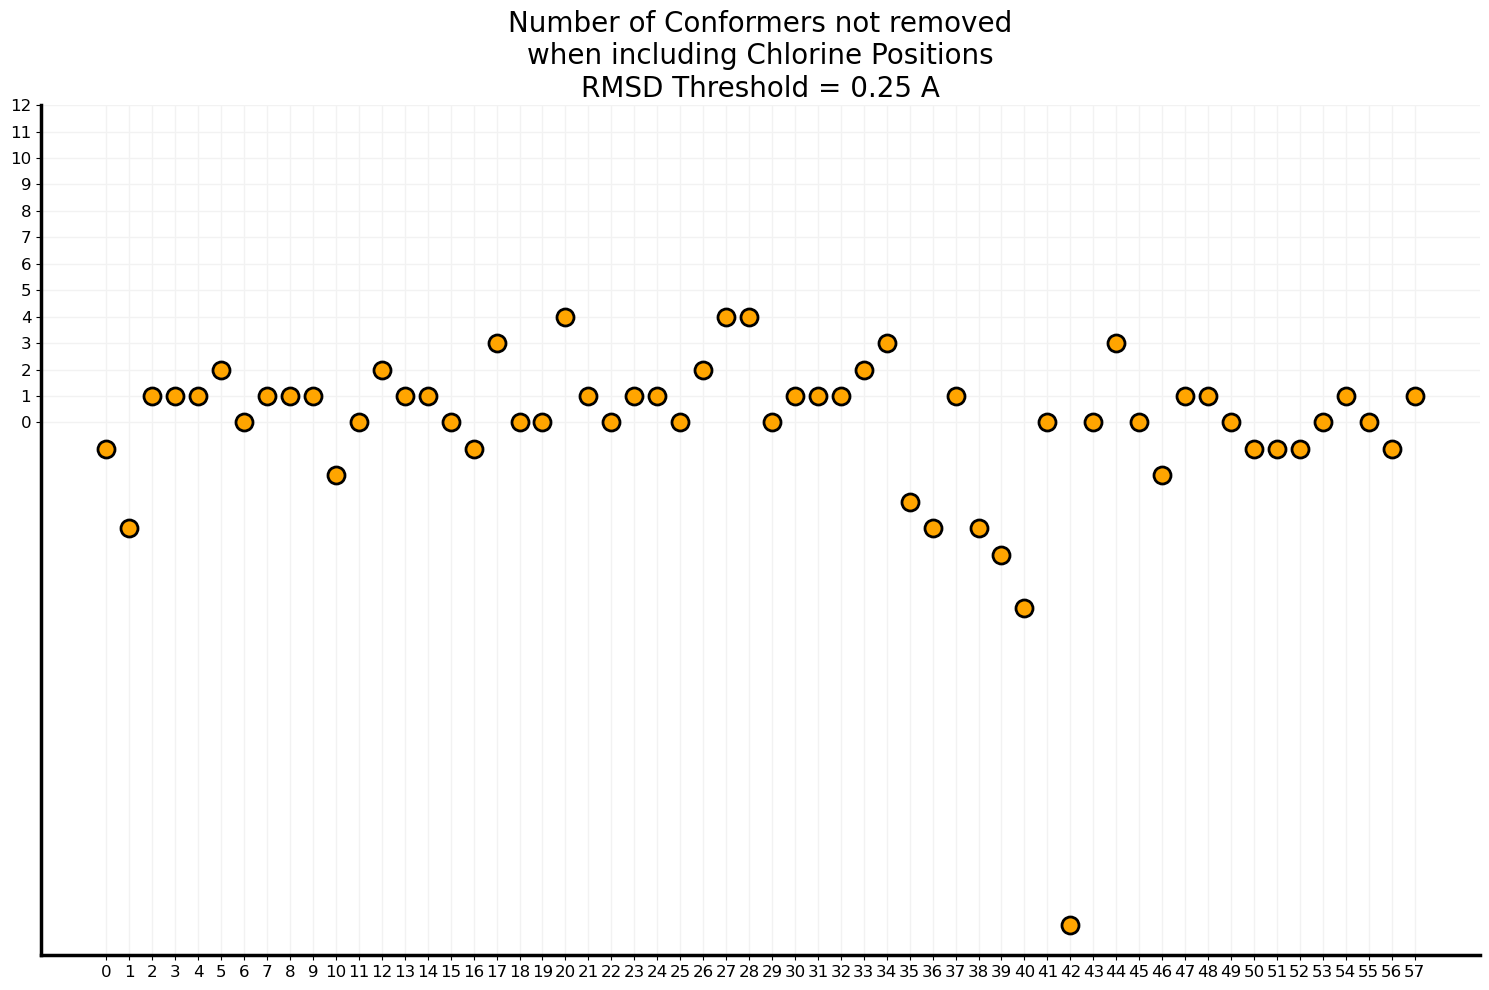

In [124]:
increases = np.zeros((58,2))
rmsd_threshold = 0.25
for i in list(range(58)):
    inc = main(f"salt_{i}/with_chlorine/CONFORMERS/", rmsd_threshold=rmsd_threshold)
    diff = inc[0,:] - inc[1,:]
    increases[i,:] = diff

fig, ax = gen_single_figure(size=(15,10))
fd_medium = {"name": "Arial", "size": 12}
fd_large = {"name": "Arial", "size": 20}
#x = [int(i["path"].split("_")[1]) for i in increases]
x = list(range(58))
plt.scatter(x, increases[:,1]-increases[:,0], s=150, color="orange", edgecolor="black", linewidth=2.0)
plt.xticks(x)
plt.yticks(list(range(13)))
plt.title(f"Number of Conformers not removed\nwhen including Chlorine Positions\nRMSD Threshold = {rmsd_threshold} A", fontdict=fd_large)
plt.tight_layout()

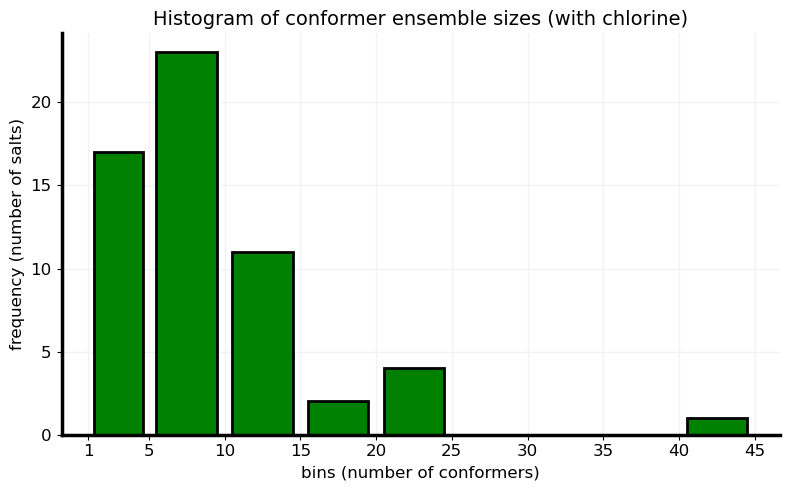

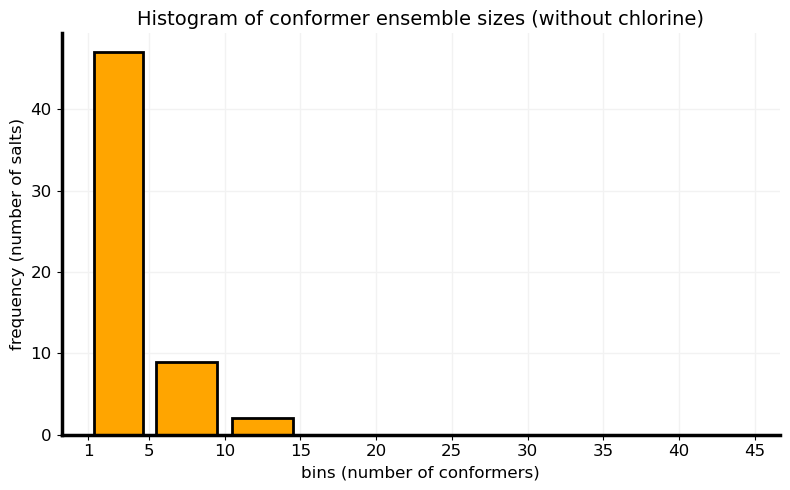

In [3]:
with_confs_sizes = []
without_confs_sizes = []
fd_medium = {"name": "Arial", "size": 12}
fd_large = {"name": "Arial", "size": 14}
for salt in os.listdir("."):
    if "salt" in salt:
        with_confs = [f for f in os.listdir(salt + "/with_chlorine/CONFORMERS/") if f.endswith(".xyz")]
        without_confs = [f for f in os.listdir(salt + "/without_chlorine/CONFORMERS/") if f.endswith(".xyz")]
        with_confs_sizes.append(len(with_confs))
        without_confs_sizes.append(len(without_confs))

fig, ax = gen_single_figure(size=(8, 5))
hist = plt.hist(with_confs_sizes, bins=[1,5,10,15,20,25,30,35,40,45], color='green', edgecolor="black", linewidth=2.0, rwidth=0.8)
plt.xticks([1,5,10,15,20,25,30,35,40,45])
plt.title("Histogram of conformer ensemble sizes (with chlorine)", fontdict=fd_large)
plt.xlabel("bins (number of conformers)", fontdict=fd_medium)
plt.ylabel("frequency (number of salts)", fontdict=fd_medium)
counts, bins = hist[0], hist[1]
plt.tight_layout()
fig.savefig("with_histogram.png")

fig, ax = gen_single_figure(size=(8, 5))
hist = plt.hist(without_confs_sizes, bins=[1,5,10,15,20,25,30,35,40,45], color='orange', edgecolor="black", linewidth=2.0, rwidth=0.8)
plt.xticks([1,5,10,15,20,25,30,35,40,45])
plt.title("Histogram of conformer ensemble sizes (without chlorine)", fontdict=fd_large)
plt.xlabel("bins (number of conformers)", fontdict=fd_medium)
plt.ylabel("frequency (number of salts)", fontdict=fd_medium)
counts, bins = hist[0], hist[1]
plt.tight_layout()
fig.savefig("without_histogram.png")

In [4]:
#run_crest_pipeline("cation_smiles.txt", 128)

In [ ]:
"""
conf_dict_with = {}
desc_dict_with = {}
conf_dict_without = {}
desc_dict_without = {}
total_with, total_without = 0, 0
for i in list(range(58)):
    print(f"----- Salt #{i} -----")
    with_ce, without_ce, best_ce = make_best_ensemble(i)
    
    n_atoms = with_ce.elements.shape[0]
    if with_ce.n_conformers > 100 or without_ce.n_conformers > 100:
        rmsd_thresh = 1.0
        energy_thresh = 1.5
    else:
        rmsd_thresh = 0.5
        energy_thresh = 3.0
    with_ce = trim_conformers(with_ce, rmsd_thresh=rmsd_thresh, energy_thresh=energy_thresh)
    conf_dict_with[i] = (with_ce, with_ce.n_conformers)
    total_with += with_ce.n_conformers
    without_ce = trim_conformers(without_ce, rmsd_thresh=rmsd_thresh, energy_thresh=energy_thresh)
    conf_dict_without[i] = (without_ce, without_ce.n_conformers)
    total_without += without_ce.n_conformers
    print(f"   Atoms: {n_atoms}, rmsd: {rmsd_thresh}, energy: {energy_thresh}, with: {with_ce.n_conformers}, without: {without_ce.n_conformers}")
    dump_conformers(with_ce, i, withh=True)
    dump_conformers(without_ce, i, withh=False)
    gen_hess(i, 64, withh=True)
    gen_hess(i, 64, withh=False)
    with_bw = with_ce.boltzmann_weights().T
    without_bw = without_ce.boltzmann_weights().T
    with_ensemble_desc = get_ensemble_descriptors(i, withh=True, dispersion=True, SASA=True, XTB=True, LFCs="N_H")
    without_ensemble_desc = get_ensemble_descriptors(i, withh=False, dispersion=True, SASA=True, XTB=True, LFCs="N_H")
    n_conformers, n_descriptors = len(list(with_ensemble_desc)), len(list(with_ensemble_desc[0].values()))
    bw_desc_with = boltz_weight_desc(with_ensemble_desc, with_bw)
    bw_desc_without = boltz_weight_desc(without_ensemble_desc, without_bw) 
    desc_dict_with[i] = bw_desc_with
    desc_dict_without[i] = bw_desc_without
def make_dfs(withh, without):
    return pd.DataFrame.from_dict(withh, orient="index"), pd.DataFrame.from_dict(without, orient="index")
with_df, without_df = make_dfs(desc_dict_with, desc_dict_without)
with_df.to_csv("descriptors_with_chlorine.csv", index=False)
without_df.to_csv("descriptors_without_chlorine.csv", index=False)
"""

In [5]:
def features():
    # Some third dimensions
    mol_wt = {}
    aromatic = {}
    bonds = {}
    sulfur = {}
    for salt in sorted(os.listdir("./")):
        if "salt_" in salt:
            n = str(salt.split("_")[1])
            SMILES = open(f"salt_{n}/with_chlorine/smiles.txt", "r").readlines()[0].replace("\n", "").split()[0]
            SMILES = SMILES.replace("[NH3]", "N").replace("[Cl]", "Cl")

            mol = Chem.MolFromSmiles(SMILES, sanitize=True)
            mol_wt[int(n)] = {"mol_wt": round(rdkit.Chem.Descriptors.MolWt(mol), 3)}
            arom = 0
            for atom in mol.GetAtoms():
                arom += atom.GetIsAromatic()
            dbonds = 0
            for bond in mol.GetBonds():
                btype = bond.GetBondType()
                if btype.name in ["DOUBLE", "AROMATIC", "TRIPLE"]:
                    dbonds += 1

            aromatic[int(n)] = {"aromatic": arom}
            bonds[int(n)] = {"n_double_bonds": dbonds}
            sulfur[int(n)] = {"sulfur": mol.HasSubstructMatch(Chem.MolFromSmiles('S'))}

    mol_wt = pd.DataFrame.from_dict(mol_wt, orient="index")
    aromatic = pd.DataFrame.from_dict(aromatic, orient="index")
    bonds = pd.DataFrame.from_dict(bonds, orient="index")
    sulfur = pd.DataFrame.from_dict(sulfur, orient="index")
    
    return mol_wt, aromatic, bonds, sulfur

In [6]:
mol_wt, aromatic, bonds, sulfur = features()

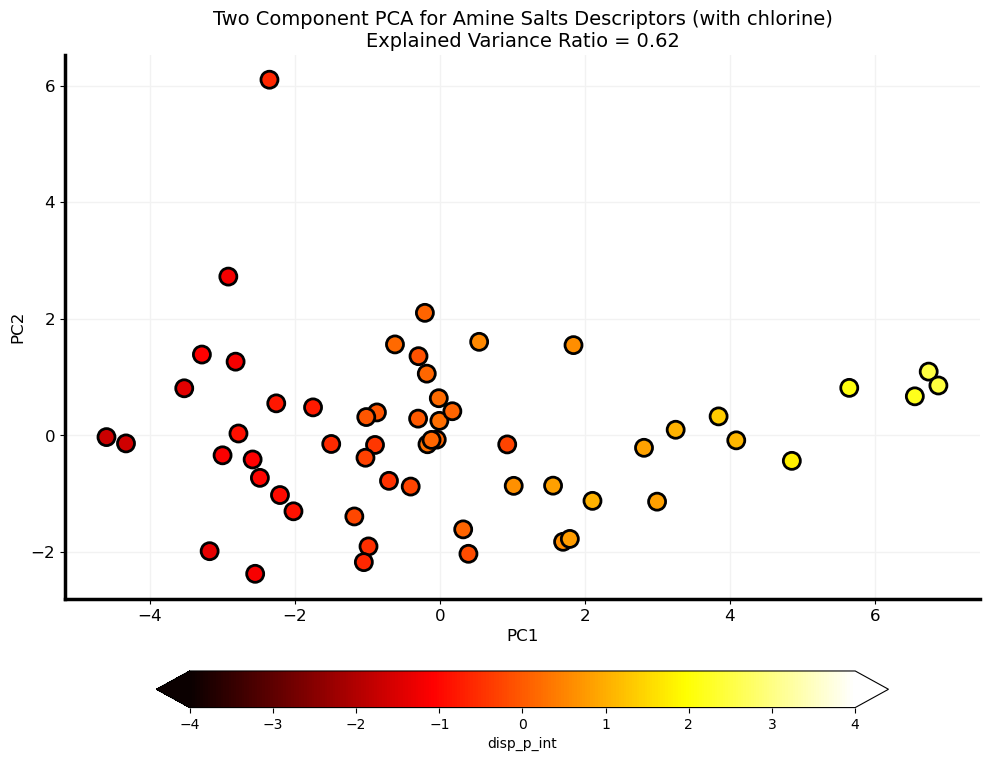

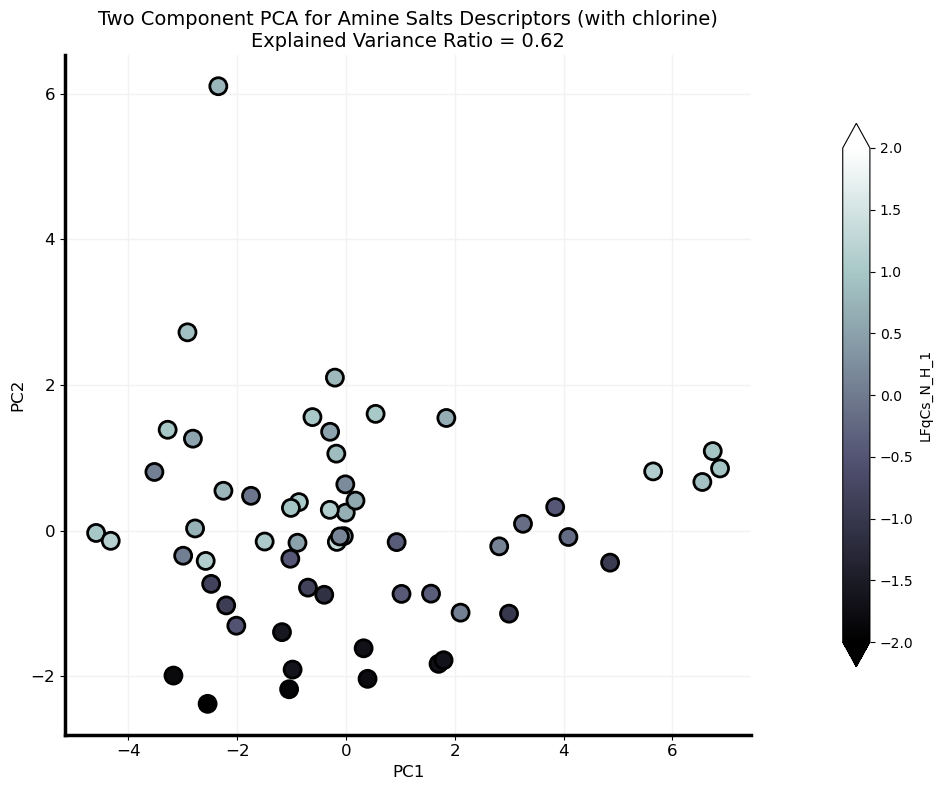

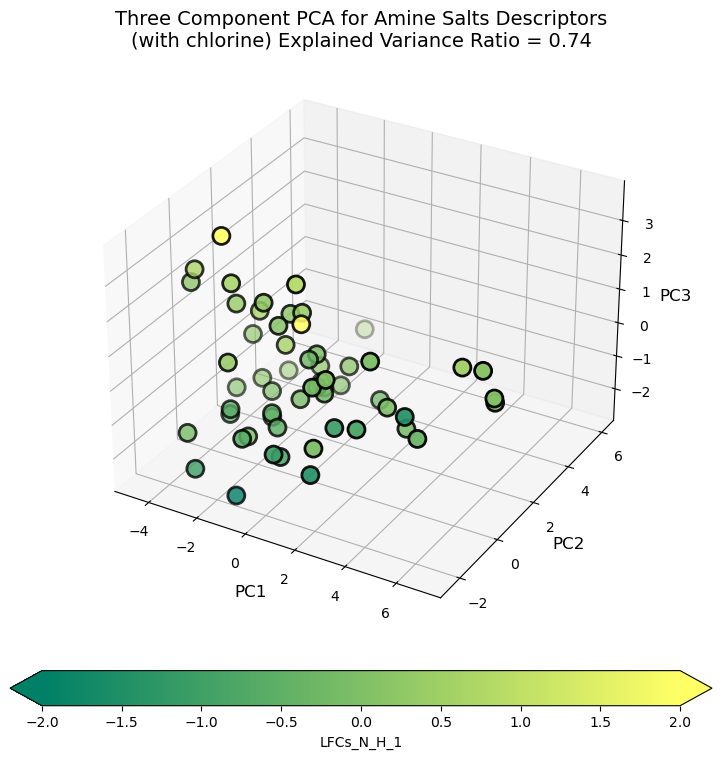

In [80]:
# define pandas DataFrame with Descriptor representation salts
df_in = pd.read_csv("descriptors_with_chlorine.csv")
columns = list(df_in.columns)

# use a StandardScaler to transform the Descriptors for PCA
df = StandardScaler().fit_transform(df_in)
df_in = pd.DataFrame(df, columns=columns)
#fit PCA
pca_2d = PCA(n_components=2)
pcas_2d = pca_2d.fit_transform(df)
pca_2d_df = pd.DataFrame(pcas_2d, columns=["PC1", "PC2"])
exp_var_ratio_2d = pca_2d.explained_variance_ratio_
pc_1_ifs = [columns[i] for i in (-pca_2d.components_).argsort()[0][:3]]
pc_2_ifs = [columns[i] for i in (-pca_2d.components_).argsort()[1][:3]]
fd_medium = {"name": "Arial", "size": 12}
fd_large = {"name": "Arial", "size": 14}
fig, ax = gen_single_figure(size = (10, 8))
plt.scatter(pca_2d_df["PC1"], pca_2d_df["PC2"], c=df_in[pc_1_ifs[0]].tolist(), cmap="hot", s = 150, edgecolor="black", linewidth=2.0, vmin=-4, vmax=4)
plt.colorbar(orientation="horizontal", extend="both", label=pc_1_ifs[0], shrink=0.8, pad=0.1)
plt.title(f"Two Component PCA for Amine Salts Descriptors (with chlorine)\nExplained Variance Ratio = {round(np.sum(exp_var_ratio_2d), 2)}", fontdict=fd_large)
#plt.xlabel(f"PC1 - {', '.join(pc_1_ifs)}", fontdict=fd_medium)
#plt.ylabel(f"PC2 - {', '.join(pc_2_ifs)}", fontdict=fd_medium)
plt.ylabel(f"PC2", fontdict=fd_medium)
plt.xlabel(f"PC1", fontdict=fd_medium)
plt.tight_layout()
fig.savefig("with_chlorine_2D_pca_horizontal_PCA.png")

fig, ax = gen_single_figure(size = (10, 8))
plt.scatter(pca_2d_df["PC1"], pca_2d_df["PC2"], c=df_in[pc_2_ifs[0]].tolist(), cmap="bone", s = 150, edgecolor="black", linewidth=2.0, vmin=-2, vmax=2)
plt.colorbar(orientation="vertical", extend="both", label=pc_2_ifs[0], shrink=0.8, pad=0.1)
plt.title(f"Two Component PCA for Amine Salts Descriptors (with chlorine)\nExplained Variance Ratio = {round(np.sum(exp_var_ratio_2d), 2)}", fontdict=fd_large)
#plt.xlabel(f"PC1 - {', '.join(pc_1_ifs)}", fontdict=fd_medium)
#plt.ylabel(f"PC2 - {', '.join(pc_2_ifs)}", fontdict=fd_medium)
plt.ylabel(f"PC2", fontdict=fd_medium)
plt.xlabel(f"PC1", fontdict=fd_medium)
plt.tight_layout()
fig.savefig("with_chlorine_2D_pca_vertical_PCA.png")

pca_3d = PCA(n_components=3)
pcas_3d = pca_3d.fit_transform(df)
pca_3d_df = pd.DataFrame(pcas_3d, columns=["PC1", "PC2", "PC3"])
exp_var_ratio_3d = pca_3d.explained_variance_ratio_
pc_1_ifs = [columns[i] for i in (-pca_3d.components_).argsort()[0][:3]]
pc_2_ifs = [columns[i] for i in (-pca_3d.components_).argsort()[1][:3]]
pc_3_ifs = [columns[i] for i in (-pca_3d.components_).argsort()[2][:3]]
#fig, ax = gen_single_figure(size = (10, 8))
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(pca_3d_df["PC1"], pca_3d_df["PC2"], pca_3d_df["PC3"], c=df_in[pc_3_ifs[0]].tolist(), cmap="summer", s=150, edgecolor="black", linewidth=2.0, vmin=-2, vmax=2)
fig.colorbar(p, orientation="horizontal", extend="both", label=pc_3_ifs[0], shrink=0.6, pad=0.05)
ax.set_title(f"Three Component PCA for Amine Salts Descriptors\n(with chlorine) Explained Variance Ratio = {round(np.sum(exp_var_ratio_3d), 2)}", fontdict=fd_large)
#ax.set_xlabel(f"PC1 - {', '.join(pc_1_ifs)}", fontdict=fd_medium)
#ax.set_ylabel(f"PC2 - {', '.join(pc_2_ifs)}", fontdict=fd_medium)
#ax.set_zlabel(f"PC3 - {', '.join(pc_3_ifs)}", fontdict=fd_medium)
ax.set_xlabel(f"PC1", fontdict=fd_medium)
ax.set_ylabel(f"PC2", fontdict=fd_medium)
ax.set_zlabel(f"PC3", fontdict=fd_medium)

plt.tight_layout()
fig.savefig("with_chlorine_3D_pca_pc_3_colormap.png")

In [ ]:
# define pandas DataFrame with Descriptor representation salts
df = pd.read_csv("descriptors_without_chlorine.csv")
columns = list(df.columns)
print(columns)
# use a StandardScaler to transform the Descriptors for PCA
df = StandardScaler().fit_transform(df)
# fit PCA
pca = PCA(n_components=2)
pcas = pca.fit_transform(df)
pca_df = pd.DataFrame(pcas, columns = ["PC 1", "PC 2"])
exp_var_ratio = pca.explained_variance_ratio_
# generate figure
fd_medium = {"name": "Arial", "size": 12}
fd_large = {"name": "Arial", "size": 14}
fig, ax = gen_single_figure(size = (10, 8))
# get top two features for each PC
pc_1_ifs = [columns[i] for i in (-pca.components_).argsort()[0][:2]]
pc_2_ifs = [columns[i] for i in (-pca.components_).argsort()[1][:2]]
# plot pcs
#plt.scatter(pca_df["PC 1"], pca_df["PC 2"], c = mol_wt.values.flatten().tolist(), cmap="copper", s = 125)
plt.scatter(pca_df["PC 1"], pca_df["PC 2"], c = "blue", s = 125)
#plt.colorbar(label="number of aromatic atoms", orientation="vertical", extend="both")
plt.title(f"Two Component PCA for Amine Salts Descriptors (without chlorine)\nExplained Variance Ratio = {round(np.sum(exp_var_ratio), 2)}", fontdict=fd_large)
plt.xlabel(f"PC 1 - {', '.join(pc_1_ifs)}", fontdict=fd_medium)
plt.ylabel(f"PC 2 - {', '.join(pc_2_ifs)}", fontdict=fd_medium)

plt.tight_layout()
fig.savefig("PCA_without_chlorine.png")

In [ ]:
pc_1 = [columns[i] for i in (-pca.components_).argsort()[0]]
pc_2 = [columns[i] for i in (-pca.components_).argsort()[1]]

In [ ]:
print(pc_1)
print(pc_2)